# Neural Style Transfer Exp:2
Context [here](https://dhruvs.space/posts/neural-style-transfer/).

Things explored:
- Varying $\alpha$ and $\beta$ ratio


In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')
DRIVE_BASE_PATH = "/content/gdrive/My\ Drive/Colab\ Notebooks/"

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!pip install -q fastai==0.7.0 torchtext==0.2.3

In [0]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
from math import ceil
from decimal import Decimal

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [0]:
class NeuralStyleTransfer(object):
    
    def __init__(self,base_model,sz):
        self.base_model = base_model
        self.sz = sz
        self.model = to_gpu(base_model(True)).eval()
        set_trainable(self.model, False)
        self.trn_tfms,self.val_tfms = tfms_from_model(self.base_model, self.sz)
        
    def get_opt(self,img):
        opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
        opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
        opt_img_v = V(self.val_tfms(opt_img/2)[None], requires_grad=True)
        return opt_img_v, optim.LBFGS([opt_img_v])
    
    def step(self,loss_fn):
        self.optimizer.zero_grad()
        loss = loss_fn(self.opt_img_v)
        loss.backward()
        self.n_iter+=1
#         if self.print_losses:
#             if self.n_iter%self.show_iter==0: print(f'Iteration: {self.n_iter}, loss: {loss.data[0]}')
        return loss

    def scale_match(self, src, targ):
        h,w,_ = src.shape
        sh,sw,_ = targ.shape
        rat = max(h/sh,w/sw); rat
        res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
        return res[:h,:w]
    
    def gram(self,input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

    def gram_mse_loss(self,input, target):
        return F.mse_loss(self.gram(input), self.gram(target))
    
    def comb_loss(self,x):
        self.model(self.opt_img_v)
        content_outs = [V(o.features) for o in self.content_sfs]
        style_outs = [V(o.features) for o in self.style_sfs]
        
#         content_loss
        content_losses   = [F.mse_loss(o, s) 
                        for o,s in zip(content_outs, self.targ_vs)]
    
#         style_loss
        style_losses = [self.gram_mse_loss(o, s) 
                        for o,s in zip(style_outs, self.targ_styles)]

    
        if self.content_layers_weights is None:
            content_loss = sum(content_losses)
        else:
            content_loss = sum([a*b for a,b in 
                                zip(content_losses,self.content_layers_weights)])
            
        if self.style_layers_weights is None:
            style_loss = sum(style_losses)
        else:
            style_loss = sum([a*b for a,b in 
                              zip(style_losses,self.style_layers_weights)])
        if self.print_losses:
            if self.n_iter%self.show_iter==0:
                print(f'content: {self.alpha*content_loss.data[0]}, style: {self.beta*style_loss.data[0]}')
        
        if self.return_intermediates and self.n_iter<=self.gif_iter_till:
            if self.n_iter%self.gif_iter==0:
                self.intermediate_images.append(self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0])
        
        return self.alpha*content_loss + self.beta*style_loss

    def generate(self, content_image, style_img,
                 style_layers, content_layers,
                 alpha=1e6,
                 beta=1.,
                 content_layers_weights=None,
                 style_layers_weights=None,
                 max_iter=500,show_iter=300,
                 print_losses=False,
                 scale_style_img=True,
                 return_intermediates=False,
                 gif_iter=50,
                 gif_iter_till=500):
        
        self.max_iter = max_iter
        self.show_iter = show_iter
        self.gif_iter = gif_iter
        self.gif_iter_till = gif_iter_till
        
        self.alpha = alpha
        self.beta = beta
        self.content_layers_weights = content_layers_weights
        self.style_layers_weights = style_layers_weights
        self.print_losses = print_losses
        self.return_intermediates = return_intermediates
        self.intermediate_images = []

        self.content_sfs = [SaveFeatures(children(self.model)[idx]) for idx in content_layers]
        
        self.style_sfs = [SaveFeatures(children(self.model)[idx]) for idx in style_layers]
        
#         get target content
        img_tfm = self.val_tfms(content_image)
        self.opt_img_v, self.optimizer = self.get_opt(content_image)
        self.model(VV(img_tfm[None]))
        self.targ_vs = [V(o.features.clone()) for o in self.content_sfs]

#         get target style
        if scale_style_img:
            style_img = self.scale_match(content_image, style_img)
        self.style_tfm = self.val_tfms(style_img)
        self.model(VV(self.style_tfm[None]))
        self.targ_styles = [V(o.features.clone()) for o in self.style_sfs]
        
        self.n_iter=0

        while self.n_iter <= self.max_iter: self.optimizer.step(partial(self.step,self.comb_loss))
        for sf in self.content_sfs: sf.close()
        for sf in self.style_sfs: sf.close()
        if not self.return_intermediates:
            return self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0]
        else:
            return self.intermediate_images

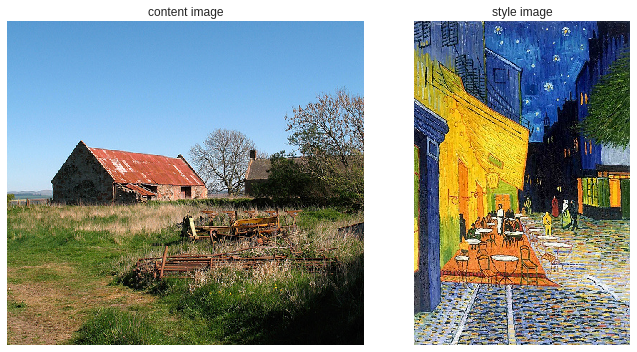

In [6]:
PATH = Path('data/imagenet')
PATH_IMAGES = PATH/'images'
PATH_STYLE = PATH/'style'

!mkdir -p {PATH_IMAGES}
!mkdir -p {PATH_STYLE}

# !wget -qq http://farm1.static.flickr.com/202/480492895_711231246a.jpg -O {PATH_IMAGES}/farm.jpg
content_img = open_image(PATH_IMAGES/'farm.jpg')

# !wget -qq https://media.overstockart.com/optimized/cache/data/product_images/VG1540-1000x1000.jpg -O {PATH_STYLE}/'cafe_terrace.jpg'
style_img = open_image(PATH_STYLE/'cafe_terrace.jpg')

images = [content_img,style_img]
titles = ['content image', 'style image']

fig,axes = plt.subplots(1,2,figsize=(10,5))
for i,ax in enumerate(axes.flat):
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(titles[i])
    ax.imshow(images[i]);
plt.tight_layout()
plt.show()

In [0]:
t2 = NeuralStyleTransfer(vgg16,288)

In [0]:
t2.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

## Varying $\alpha$ and $\beta$ ratio

Reconstructing with ratio 1.00E+4...
content: 3448.174148797989, style: 1322204.58984375
content: 4377.418011426926, style: 17081.039428710938
content: 4020.491987466812, style: 6291.548538208008
content: 3677.9969930648804, style: 3019.9987411499023
content: 3374.548628926277, style: 1750.3353118896484
content: 3096.8360602855682, style: 1132.7113151550293
content: 2876.9325464963913, style: 833.7692260742188
content: 2697.9001238942146, style: 677.2781372070312
content: 2560.6416165828705, style: 588.8765335083008
content: 2452.884428203106, style: 533.978796005249
content: 2364.3430322408676, style: 498.5119819641113
Reconstructing with ratio 2.00E+4...
content: 3449.7935324907303, style: 667205.029296875
content: 4222.535341978073, style: 8414.944458007812
content: 3627.8747022151947, style: 3252.4948120117188
content: 3154.8313796520233, style: 1706.2955856323242
content: 2808.6692094802856, style: 1075.2546310424805
content: 2539.0006601810455, style: 768.5184478759766
content: 2

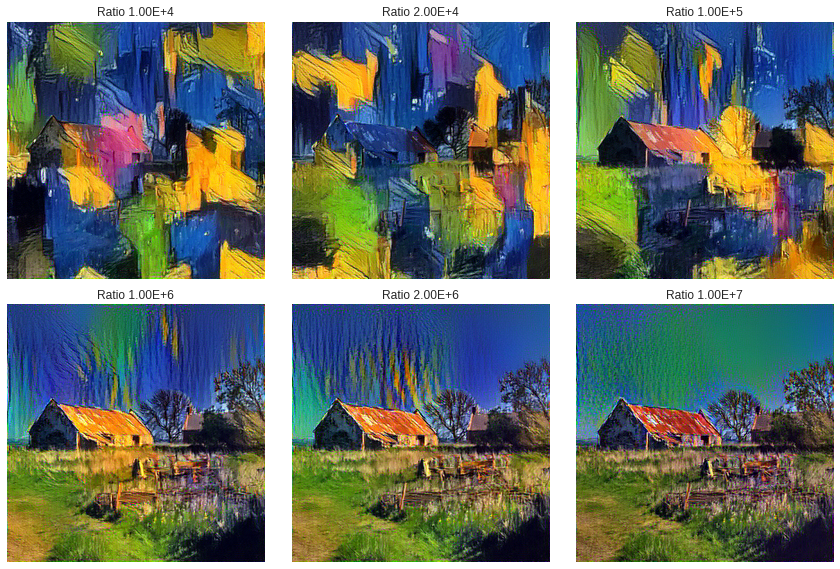

In [9]:
betas = [1e2,5e1,1e1,1.,5e-1,1e-1]
alpha= 1e6
ratios = ["{:.2E}".format(Decimal(alpha/b)) for b in betas]

n_cols = 3
n_rows = ceil(len(ratios)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

for i,ax in enumerate(axes.flat):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if i==len(ratios):
        break
    print(f'Reconstructing with ratio {ratios[i]}...')
    

    ax.set_title(f'Ratio {ratios[i]}')
    gen4 = t2.generate(content_img, style_img,
                       content_layers=[19,22],
                       style_layers=[9,12,16,22,],
                       alpha=1e5,
                       beta=betas[i],
                       style_layers_weights=None,
                       max_iter=1000,show_iter=100,
                       print_losses=True,
                       scale_style_img=True)
    x = np.clip(gen4, 0, 1)
    ax.imshow(x,interpolation='lanczos')
plt.tight_layout()   
fig_name = f'v2-alpha-beta-ratios-1.png'
plt.savefig(fig_name)
plt.show()
!cp {fig_name} {DRIVE_BASE_PATH}saved_models/fai_part_2/lec13/

In [0]:
paintings = {
    "van_gogh_self_portrait":"https://cdn.shopify.com/s/files/1/0223/4033/products/V495_bfc78f33-3b1a-40ec-bd64-f85c4ec05fa4_1024x1024.jpg",
    "kanagawa_wave":"https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/The_Great_Wave_off_Kanagawa.jpg/1024px-The_Great_Wave_off_Kanagawa.jpg",
    "the_scream":"https://images-na.ssl-images-amazon.com/images/I/81Z7qbHAjDL._SY679_.jpg",
    "the_night_cafe":"http://cdn.artobserved.com/2009/03/vincent-van-gogh-the-night-cafe-1888-via-artstor-collections.jpg"
}

In [11]:
for painting in paintings:
    print(f'!wget -qq "{paintings[painting]}" -O {PATH_STYLE}/{painting}.jpg')
    !wget -qq "{paintings[painting]}" -O {PATH_STYLE}/{painting}.jpg

!wget -qq "https://cdn.shopify.com/s/files/1/0223/4033/products/V495_bfc78f33-3b1a-40ec-bd64-f85c4ec05fa4_1024x1024.jpg" -O data/imagenet/style/van_gogh_self_portrait.jpg
!wget -qq "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/The_Great_Wave_off_Kanagawa.jpg/1024px-The_Great_Wave_off_Kanagawa.jpg" -O data/imagenet/style/kanagawa_wave.jpg
!wget -qq "https://images-na.ssl-images-amazon.com/images/I/81Z7qbHAjDL._SY679_.jpg" -O data/imagenet/style/the_scream.jpg
!wget -qq "http://cdn.artobserved.com/2009/03/vincent-van-gogh-the-night-cafe-1888-via-artstor-collections.jpg" -O data/imagenet/style/the_night_cafe.jpg


In [0]:
style_paintings = []
paintings_names = []

for painting in paintings:
    try:
        style_paintings.append(open_image(f'{PATH_STYLE}/{painting}.jpg'))
        paintings_names.append(painting)
    except Exception as e:
        print(str(e))

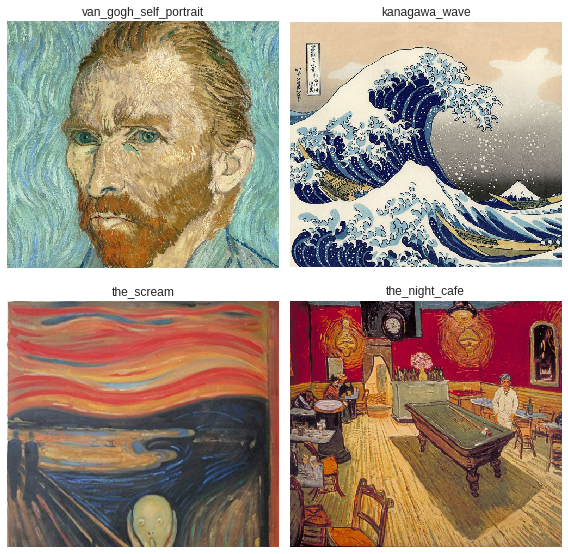

In [14]:
n_cols = 2
n_rows = ceil(len(style_paintings)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

for i,ax in enumerate(axes.flat):
        
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{paintings_names[i]}')
    ax.imshow(t2.scale_match(content_img, style_paintings[i]))
plt.tight_layout()
plt.show()

In [0]:
def show_generated_images(style_paintings,paintings_names,content_img,
                         n_cols=2,
                         alpha=1e5,
                         beta=1.):
    n_cols = n_cols
    n_rows = ceil(len(style_paintings)/n_cols)

    fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

    for i,ax in enumerate(axes.flat):
        if i==len(style_paintings):
            break

        print(f'Generating {i+1}: {paintings_names[i]}...')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{paintings_names[i]}')
        gen4 = t2.generate(content_img, style_paintings[i],
                           content_layers=[19,22],
                           style_layers=[9,12,16,22,],
                           alpha=alpha,
                           beta=beta,
                           max_iter=1000,show_iter=100,
                           print_losses=True)

        x = np.clip(gen4, 0, 1)
        ax.imshow(x,interpolation='lanczos')
    plt.tight_layout()   
    fig_name = f'v2-paintings-2.png'
    plt.savefig(fig_name)
    plt.show()
    !cp {fig_name} {DRIVE_BASE_PATH}saved_models/fai_part_2/lec13/

Generating 1: van_gogh_self_portrait...
content: 3467.23236143589, style: 38730.0908203125
content: 1010.9573602676392, style: 348.62647247314453
content: 653.3436477184296, style: 190.22323608398438
content: 567.722599953413, style: 172.27205657958984
content: 533.8142160326242, style: 166.46075820922852
content: 515.618734061718, style: 163.94876861572266
content: 504.11829724907875, style: 162.8510513305664
content: 496.4561201632023, style: 162.13309478759766
content: 490.42683094739914, style: 162.03016662597656
content: 485.68379133939743, style: 161.9212532043457
content: 481.8354733288288, style: 161.85889434814453
Generating 2: kanagawa_wave...
content: 3446.890041232109, style: 64007.208984375
content: 2300.470694899559, style: 1494.977783203125
content: 1854.5832484960556, style: 821.0555419921875
content: 1615.6602650880814, style: 612.9661102294922
content: 1465.6629413366318, style: 507.5580139160156
content: 1364.9459928274155, style: 443.8598327636719
content: 1291.8276

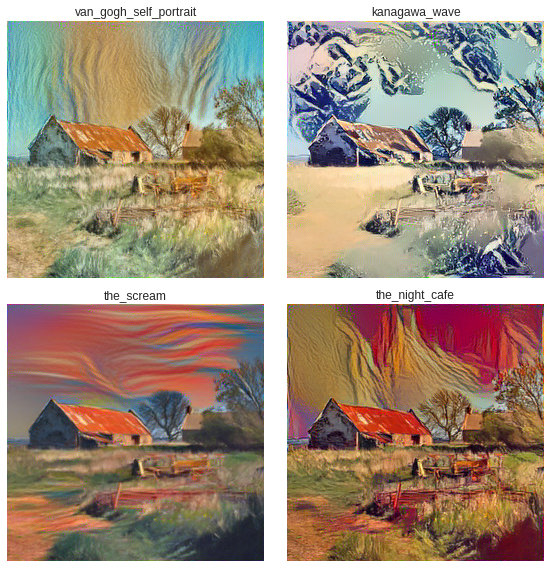

In [21]:
show_generated_images(style_paintings,paintings_names,content_img,beta=3.)